This notebook is for the resolution of the ML project 

*Importing the data 

In [88]:
import pandas as pd 


In [89]:
df = pd.read_csv('nat2022.csv', sep=';')
df.head()

,sexe,preusuel,annais,nombre
0,1,_PRENOMS_RARES,1900,1249
1,1,_PRENOMS_RARES,1901,1342
2,1,_PRENOMS_RARES,1902,1330
3,1,_PRENOMS_RARES,1903,1286
4,1,_PRENOMS_RARES,1904,1430


*start of data cleaning

In [90]:
#renaming columns
df.columns = ["sex", "name", "year", 'count']
df.head()

,sex,name,year,count
0,1,_PRENOMS_RARES,1900,1249
1,1,_PRENOMS_RARES,1901,1342
2,1,_PRENOMS_RARES,1902,1330
3,1,_PRENOMS_RARES,1903,1286
4,1,_PRENOMS_RARES,1904,1430


In [91]:
#exclude all _PRENOMS_RARES
df = df[df['name'] != '_PRENOMS_RARES']
df.head()

,sex,name,year,count
123,1,A,1980,3
124,1,A,1998,3
125,1,A,XXXX,21
126,1,AADAM,2009,4
127,1,AADAM,2014,3


In [92]:
#exclude all names with '-'
df = df[df['name'].str.contains('-') == False]
df.head()

,sex,name,year,count
123,1,A,1980,3
124,1,A,1998,3
125,1,A,XXXX,21
126,1,AADAM,2009,4
127,1,AADAM,2014,3


In [93]:
#regroup all the name while ignoring sex
df = df.groupby(['name', 'year'])['count'].sum().reset_index()
df.head()

,name,year,count
0,A,1980,3
1,A,1998,3
2,A,XXXX,21
3,AADAM,2009,4
4,AADAM,2014,3


In [94]:
# delete all rows that have a non-numeric value in the year column
df = df[df['year'].str.isnumeric()]
df.head()

,name,year,count
0,A,1980,3
1,A,1998,3
3,AADAM,2009,4
4,AADAM,2014,3
5,AADAM,2015,3


In [95]:
#change type of year column to int
df['year'] = df['year'].astype(int)
df.head()

,name,year,count
0,A,1980,3
1,A,1998,3
3,AADAM,2009,4
4,AADAM,2014,3
5,AADAM,2015,3


In [96]:
# sort by year and name
df = df.sort_values(['year', 'name'])
df.head()

,name,year,count
4389,ABDON,1900,4
5400,ABEL,1900,428
5550,ABELINE,1900,3
5593,ABELLE,1900,3
6626,ABRAHAM,1900,19


*Regrouping similar names by using Levenshtein distance

In [97]:
from Levenshtein import distance
from sklearn.cluster import DBSCAN
from collections import defaultdict
import numpy as np


In [104]:
def group_similar_names(df, max_distance=2):
    """
    Group similar names using Levenshtein distance across all years,
    then sum counts by year for each name group.
    
    Parameters:
    - df: DataFrame with columns 'name', 'year', 'count'
    - max_distance: Maximum Levenshtein distance to consider names similar
    
    Returns:
    - DataFrame with grouped names and their combined counts by year
    """
    # Get unique names across all years
    unique_names = list(df['name'].unique())
    
    # Calculate total frequency for each name (across all years)
    name_frequencies = df.groupby('name')['count'].sum().to_dict()
    
    # Sort names by their total frequency (most frequent first)
    sorted_names = sorted(unique_names, key=lambda name: name_frequencies.get(name, 0), reverse=True)
    
    # Create name clusters
    name_clusters = []
    processed_names = set()
    
    for name in sorted_names:
        if name not in processed_names:
            cluster = [name]
            processed_names.add(name)
            
            # Find similar names to add to this cluster
            for other_name in sorted_names:
                if other_name != name and other_name not in processed_names:
                    if distance(name, other_name) <= max_distance:
                        cluster.append(other_name)
                        processed_names.add(other_name)
            
            name_clusters.append(cluster)
    
    # Create mapping from original name to representative name
    name_mapping = {}
    for cluster in name_clusters:
        representative = cluster[0]  # Use most frequent name as representative
        for name in cluster:
            name_mapping[name] = representative
    
    # Store similar names for each representative
    similar_names_dict = {}
    for cluster in name_clusters:
        if len(cluster) > 1:
            representative = cluster[0]
            similar_names_dict[representative] = cluster[1:]
        else:
            similar_names_dict[cluster[0]] = []
    
    # Apply mapping and group by representative name and year
    df_with_mapping = df.copy()
    df_with_mapping['representative_name'] = df_with_mapping['name'].map(name_mapping)
    
    # Group by representative name and year, summing the counts
    result = df_with_mapping.groupby(['representative_name', 'year'], as_index=False)['count'].sum()
    
    # Add similar names information
    result['similar_names'] = result['representative_name'].apply(
        lambda name: similar_names_dict.get(name, [])
    )
    
    # Rename representative_name back to name for consistency
    result = result.rename(columns={'representative_name': 'name'})
    
    # Check if all names are accounted for (for validation)
    original_total = df['count'].sum()
    result_total = result['count'].sum()
    
    if original_total != result_total:
        print(f"WARNING: Count totals don't match! Original: {original_total}, Result: {result_total}")
    else:
        print(f"All counts accounted for. Total: {original_total}")
    result = result.sort_values(['year', 'name'])
    return result


In [106]:
cluster= group_similar_names(df, max_distance=2)
cluster.head()

All counts accounted for. Total: 82844134


,name,year,count,similar_names
1935,ACHILLE,1900,266,"[RACHELLE, ACHILE, ACHILLES]"
2177,ADAM,1900,26,"[AMAR, AKIM, ADAMA, VADIM, AIDA, AKRAM, AYDAN,..."
2306,ADELAIDE,1900,197,"[ADÉLAÏDE, ADELIE, ADELAÏDE, ADÉLAIDE, ADELAIS..."
2429,ADELHEID,1900,3,[]
2442,ADELIA,1900,30,"[ADELIN, ODELIA, ACELYA, DELHIA, ADELINO, AZEL..."


In [107]:
cluster["cluster_size"] = cluster['similar_names'].apply(len)
cluster.head(20)

,name,year,count,similar_names,cluster_size
1935,ACHILLE,1900,266,"[RACHELLE, ACHILE, ACHILLES]",3
2177,ADAM,1900,26,"[AMAR, AKIM, ADAMA, VADIM, AIDA, AKRAM, AYDAN,...",126
2306,ADELAIDE,1900,197,"[ADÉLAÏDE, ADELIE, ADELAÏDE, ADÉLAIDE, ADELAIS...",6
2429,ADELHEID,1900,3,[],0
2442,ADELIA,1900,30,"[ADELIN, ODELIA, ACELYA, DELHIA, ADELINO, AZEL...",44
2580,ADHEMAR,1900,5,"[ADHÉMAR, SHEMAR]",2
2687,ADONIS,1900,22,"[ADONAÏ, ADONYS, ADONAI, ADONAY, DIONIS, APONI...",10
2843,ADRIEN,1900,1880,"[ADRIENNE, HADRIEN, ADRIAN, ADRIANA, ADRIANO, ...",31
3003,AGATHE,1900,115,"[AGATHA, AGATE, AGATA, AGATHON, AMATH, AMANTHE...",13
3157,AGLAE,1900,23,"[AGLAÉ, AHLAME, AGLAEE, ADLANE, ATLAS, ABLAYE,...",12


#Feature engineering 
  

In [113]:
from tqdm import tqdm
from scipy import stats

In [117]:
def engineer_features(df):
    """
    Create features for predicting when a name will become popular again.
    
    Parameters:
    df (pandas.DataFrame): DataFrame with columns 'name', 'year', 'count'
    
    Returns:
    pandas.DataFrame: DataFrame with engineered features
    """
    # Make a copy of the dataframe to avoid modifying the original
    result_df = df.copy()
    
    # Group by name to process each name's time series
    name_groups = []
    
    for name, group in df.groupby('name'):
        # Sort by year to ensure chronological order
        group = group.sort_values('year')
        
        # --- Trend-based features ---
        
        # Rolling averages
        group['rolling_avg_3yr'] = group['count'].rolling(window=3, min_periods=1).mean()
        group['rolling_avg_5yr'] = group['count'].rolling(window=5, min_periods=1).mean()
        group['rolling_avg_10yr'] = group['count'].rolling(window=10, min_periods=1).mean()
        
        # Rate of change (year-over-year)
        group['yoy_change'] = group['count'].pct_change(periods=1)
        
        # Acceleration (change in rate of change)
        group['acceleration'] = group['yoy_change'].pct_change(periods=1)
        
        # Peak detection (1 if local maximum, 0 otherwise)
        # A point is a peak if it's greater than both neighbors
        group['is_peak'] = 0
        for i in range(1, len(group) - 1):
            if group['count'].iloc[i] > group['count'].iloc[i-1] and \
               group['count'].iloc[i] > group['count'].iloc[i+1]:
                group.loc[group.index[i], 'is_peak'] = 1
        
        # --- Cyclical features ---
        
        # Years since last peak
        group['years_since_peak'] = 0
        last_peak_idx = -1
        for i in range(len(group)):
            if group['is_peak'].iloc[i] == 1:
                last_peak_idx = i
            if last_peak_idx >= 0:
                group.loc[group.index[i], 'years_since_peak'] = i - last_peak_idx
        
        # Find local minimums (troughs)
        group['is_trough'] = 0
        for i in range(1, len(group) - 1):
            if group['count'].iloc[i] < group['count'].iloc[i-1] and \
               group['count'].iloc[i] < group['count'].iloc[i+1]:
                group.loc[group.index[i], 'is_trough'] = 1
        
        # Years since last trough
        group['years_since_trough'] = 0
        last_trough_idx = -1
        for i in range(len(group)):
            if group['is_trough'].iloc[i] == 1:
                last_trough_idx = i
            if last_trough_idx >= 0:
                group.loc[group.index[i], 'years_since_trough'] = i - last_trough_idx
        
        # --- Statistical features ---
        
        # Z-score of current count relative to historical data
        group['count_zscore'] = stats.zscore(group['count'], nan_policy='omit')
        
        # Percentile rank of current year compared to previous years
        group['percentile_rank'] = group['count'].rank(pct=True)
        
        # Volatility (rolling standard deviation)
        group['volatility_5yr'] = group['count'].rolling(window=5, min_periods=1).std()
        group['volatility_10yr'] = group['count'].rolling(window=10, min_periods=1).std()
        
        # --- Historical pattern features ---
        
        # Historical maximum up to current point
        group['historical_max'] = group['count'].cummax()
        
        # Ratio of current count to historical maximum
        group['ratio_to_max'] = group['count'] / group['historical_max']
        
        # Count trajectory (1: increasing, -1: decreasing, 0: stable)
        group['trajectory'] = np.sign(group['yoy_change'])
        
        # Moving average trajectory (smoother signal, less noise)
        group['ma_trajectory'] = np.sign(group['rolling_avg_5yr'].diff())
        
        # Cumulative years of consecutive increase/decrease
        group['consecutive_trend'] = 0
        current_trend = 0
        for i in range(1, len(group)):
            if group['yoy_change'].iloc[i] > 0:
                if current_trend > 0:
                    current_trend += 1
                else:
                    current_trend = 1
            elif group['yoy_change'].iloc[i] < 0:
                if current_trend < 0:
                    current_trend -= 1
                else:
                    current_trend = -1
            group.loc[group.index[i], 'consecutive_trend'] = current_trend
        
        # Generation length proxy (typically 20-30 years)
        # Hypothesis: Names might repeat in popularity every generation
        group['generation_cycle'] = np.sin(2 * np.pi * group['years_since_peak'] / 25)
        
        # Add to our collection
        name_groups.append(group)
    
    # Combine all processed groups back into a single DataFrame
    result_df = pd.concat(name_groups)
    
    # Fill NaN values that might have been created during calculations
    result_df = result_df.fillna(0)
    result_df = result_df.sort_values(['year', 'name'])
    return result_df

In [118]:
test = engineer_features(cluster)
test.head()

/var/folders/v8/7zk12vv11870ydlrk_vx0vbm0000gn/T/ipykernel_69965/1353166694.py:32: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  group['acceleration'] = group['yoy_change'].pct_change(periods=1)
/var/folders/v8/7zk12vv11870ydlrk_vx0vbm0000gn/T/ipykernel_69965/1353166694.py:32: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  group['acceleration'] = group['yoy_change'].pct_change(periods=1)
/var/folders/v8/7zk12vv11870ydlrk_vx0vbm0000gn/T/ipykernel_69965/1353166694.py:32: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either f

,name,year,count,similar_names,cluster_size,rolling_avg_3yr,rolling_avg_5yr,rolling_avg_10yr,yoy_change,acceleration,...,count_zscore,percentile_rank,volatility_5yr,volatility_10yr,historical_max,ratio_to_max,trajectory,ma_trajectory,consecutive_trend,generation_cycle
1935,ACHILLE,1900,266,"[RACHELLE, ACHILE, ACHILLES]",3,266.0,266.0,266.0,0.0,0.0,...,0.526405,0.723577,0.0,0.0,266,1.0,0.0,0.0,0,0.0
2177,ADAM,1900,26,"[AMAR, AKIM, ADAMA, VADIM, AIDA, AKRAM, AYDAN,...",126,26.0,26.0,26.0,0.0,0.0,...,-0.541217,0.182927,0.0,0.0,26,1.0,0.0,0.0,0,0.0
2306,ADELAIDE,1900,197,"[ADÉLAÏDE, ADELIE, ADELAÏDE, ADÉLAIDE, ADELAIS...",6,197.0,197.0,197.0,0.0,0.0,...,0.869613,0.825203,0.0,0.0,197,1.0,0.0,0.0,0,0.0
2429,ADELHEID,1900,3,[],0,3.0,3.0,3.0,0.0,0.0,...,-0.824485,0.307692,0.0,0.0,3,1.0,0.0,0.0,0,0.0
2442,ADELIA,1900,30,"[ADELIN, ODELIA, ACELYA, DELHIA, ADELINO, AZEL...",44,30.0,30.0,30.0,0.0,0.0,...,-0.362074,0.583333,0.0,0.0,30,1.0,0.0,0.0,0,0.0


# machine learning 

In [123]:
def create_target_variable(df, prediction_window=10):
    """
    Create a target variable that indicates whether a name will become more popular
    in the next N years compared to the current year.
    
    Parameters:
    df (pandas.DataFrame): DataFrame with columns 'name', 'year', 'count'
    prediction_window (int): Number of years ahead to predict
    
    Returns:
    pandas.DataFrame: DataFrame with target variables
    """
    result_df = df.copy()
    
    # Initialize target columns
    result_df['will_increase'] = 0
    result_df['future_max_count'] = 0
    result_df['years_to_peak'] = 0
    
    for name, group in tqdm(df.groupby('name')):
        group = group.sort_values('year')
        years = group['year'].unique()
        
        for i, year in enumerate(years[:-prediction_window]):  # Skip last N years where we don't have future data
            current_count = group[group['year'] == year]['count'].values[0]
            future_years = group[(group['year'] > year) & (group['year'] <= year + prediction_window)]
            
            if len(future_years) > 0:
                future_max = future_years['count'].max()
                future_max_year = future_years.loc[future_years['count'].idxmax(), 'year']
                
                # Will the name increase in popularity in the future?
                will_increase = 1 if future_max > current_count else 0
                
                # How many years until the peak?
                years_to_peak = future_max_year - year if will_increase else 0
                
                # Update the result dataframe
                result_df.loc[(result_df['name'] == name) & (result_df['year'] == year), 'will_increase'] = will_increase
                result_df.loc[(result_df['name'] == name) & (result_df['year'] == year), 'future_max_count'] = future_max
                result_df.loc[(result_df['name'] == name) & (result_df['year'] == year), 'years_to_peak'] = years_to_peak
    
    return result_df

In [124]:
target = create_target_variable(test, prediction_window=10)
target.head()

100%|██████████| 4207/4207 [20:55<00:00,  3.35it/s]


,name,year,count,similar_names,cluster_size,rolling_avg_3yr,rolling_avg_5yr,rolling_avg_10yr,yoy_change,acceleration,...,volatility_10yr,historical_max,ratio_to_max,trajectory,ma_trajectory,consecutive_trend,generation_cycle,will_increase,future_max_count,years_to_peak
1935,ACHILLE,1900,266,"[RACHELLE, ACHILE, ACHILLES]",3,266.0,266.0,266.0,0.0,0.0,...,0.0,266,1.0,0.0,0.0,0,0.0,1,341,6
2177,ADAM,1900,26,"[AMAR, AKIM, ADAMA, VADIM, AIDA, AKRAM, AYDAN,...",126,26.0,26.0,26.0,0.0,0.0,...,0.0,26,1.0,0.0,0.0,0,0.0,1,32,5
2306,ADELAIDE,1900,197,"[ADÉLAÏDE, ADELIE, ADELAÏDE, ADÉLAIDE, ADELAIS...",6,197.0,197.0,197.0,0.0,0.0,...,0.0,197,1.0,0.0,0.0,0,0.0,0,193,0
2429,ADELHEID,1900,3,[],0,3.0,3.0,3.0,0.0,0.0,...,0.0,3,1.0,0.0,0.0,0,0.0,1,6,10
2442,ADELIA,1900,30,"[ADELIN, ODELIA, ACELYA, DELHIA, ADELINO, AZEL...",44,30.0,30.0,30.0,0.0,0.0,...,0.0,30,1.0,0.0,0.0,0,0.0,1,33,2


In [125]:
# erasing the last 10 years
max_year = target['year'].max() - 10
target_m_10 = target[target['year'] <= max_year]
target_m_10.tail()



,name,year,count,similar_names,cluster_size,rolling_avg_3yr,rolling_avg_5yr,rolling_avg_10yr,yoy_change,acceleration,...,volatility_10yr,historical_max,ratio_to_max,trajectory,ma_trajectory,consecutive_trend,generation_cycle,will_increase,future_max_count,years_to_peak
147890,ZÉPHYR,2012,28,"[ZEPHYR, ZÉPHIR, SAPHYR]",3,29.666667,24.2,18.2,-0.151515,-1.848485,...,8.495751,33,0.848485,-1.0,1.0,-1,0.248690,1,105,10
147918,ÉLOANNE,2012,3,"[CLEANNE, CLÉANNE]",2,3.333333,3.8,3.8,-0.250000,-1.750000,...,1.303840,6,0.500000,-1.0,-1.0,-1,0.248690,0,0,0
147946,ÉLOI,2012,52,"[ÉLOAN, ELFI, ÉLIOS, HÉLORI, KLOË, YLLI]",6,36.000000,24.4,14.6,0.300000,-0.800000,...,17.193022,52,1.000000,1.0,1.0,3,0.844328,1,155,8
147966,ÉLÉANA,2012,80,"[LÉVANA, TÉANA, KÉLIANA, HÉLÉANA, LÉHANA, HÉLI...",7,44.666667,28.0,15.8,0.777778,-0.805556,...,26.020505,80,1.000000,1.0,1.0,3,0.000000,1,122,7
148039,ÖMER,2012,41,"[MEIR, MEÏR, UMEYR]",3,32.000000,23.2,15.9,0.322581,0.105991,...,11.957796,41,1.000000,1.0,1.0,3,0.844328,1,76,4


In [134]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

In [136]:
def analyze_multiple_models(df):
    """
    Train and compare multiple models for name popularity prediction.
    
    Parameters:
    df (pandas.DataFrame): DataFrame with engineered features and target variables
    
    Returns:
    dict: Comparison of model performances
    """
    # Features to use in the models
    features = [
        'count', 'rolling_avg_3yr', 'rolling_avg_5yr', 'rolling_avg_10yr',
        'yoy_change', 'acceleration', 'is_peak', 'years_since_peak',
        'is_trough', 'years_since_trough', 'count_zscore', 'percentile_rank',
        'volatility_5yr', 'volatility_10yr', 'ratio_to_max', 'consecutive_trend',
        'generation_cycle'
    ]
    
    # Target variable - years until the name becomes popular again
    target = 'years_to_peak'
    
    # Drop rows with missing values
    modeling_data = df.dropna(subset=features + [target])
    
    # Split into features and target
    X = modeling_data[features]
    y = modeling_data[target]
    
    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Handle any potential remaining issues in the data
    X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Models to compare
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
        "XGBoost": XGBRegressor(n_estimators=100, random_state=42)
    }
    
    # Train and evaluate each model
    results = {}
    
    for name, model in tqdm(models.items()):
        # Train the model
        model.fit(X_train_scaled, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test_scaled)
        
        # Calculate metrics
        results[name] = {
            'MAE': mean_absolute_error(y_test, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
            'R2': r2_score(y_test, y_pred)
        }
    
    return results

In [137]:
compare = analyze_multiple_models(target_m_10)
compare

100%|██████████| 4/4 [01:20<00:00, 20.16s/it]


{'Linear Regression': {'MAE': 2.9330562704068495,
  'RMSE': 3.412616987955568,
  'R2': 0.23357303086397718},
 'Random Forest': {'MAE': 2.3047787965610724,
  'RMSE': 2.9199505989083954,
  'R2': 0.43889170444108283},
 'Gradient Boosting': {'MAE': 2.572049962820213,
  'RMSE': 3.105518401826869,
  'R2': 0.3653067265137775},
 'XGBoost': {'MAE': 2.369901092404315,
  'RMSE': 2.968421587284969,
  'R2': 0.42010836487252234}}

In [147]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

def create_binary_target(df, prediction_window=10):
    """
    Create a binary target variable that indicates whether a name will be more 
    popular in the future compared to the current year.
    
    Parameters:
    df (pandas.DataFrame): DataFrame with columns 'name', 'year', 'count'
    prediction_window (int): Number of years ahead to predict
    
    Returns:
    pandas.DataFrame: DataFrame with binary target variable
    """
    result_df = df.copy()
    
    # Initialize target column
    result_df['will_be_more_popular'] = None
    
    for name, group in tqdm(df.groupby('name')):
        group = group.sort_values('year')
        years = group['year'].unique()
        
        for i, year in enumerate(years[:-prediction_window]):  # Skip last N years where we don't have future data
            current_count = group[group['year'] == year]['count'].values[0]
            future_years = group[(group['year'] > year) & (group['year'] <= year + prediction_window)]
            
            if len(future_years) > 0:
                # Calculate average count in future years to smooth out noise
                future_avg_count = future_years['count'].mean()
                
                # Binary classification: Will it be more popular?
                will_be_more_popular = 1 if future_avg_count > current_count else 0
                
                # Update the result dataframe
                result_df.loc[
                    (result_df['name'] == name) & (result_df['year'] == year), 
                    'will_be_more_popular'
                ] = will_be_more_popular
    
    return result_df

def train_popularity_classifier(df, prediction_window=10):
    """
    Train a binary classifier to predict if a name will be more popular 
    in the next N years.
    
    Parameters:
    df (pandas.DataFrame): DataFrame with engineered features
    prediction_window (int): Number of years ahead to predict for
    
    Returns:
    tuple: (trained_model, evaluation_metrics, feature_importances)
    """
    # Create binary target if it doesn't exist
    if 'will_be_more_popular' not in df.columns:
        df = create_binary_target(df, prediction_window)
    
    # Features to use in the model - customize this list based on your data
    features = [
        'count', 'rolling_avg_3yr', 'rolling_avg_5yr', 'rolling_avg_10yr',
        'yoy_change', 'acceleration', 'is_peak', 'years_since_peak',
        'is_trough', 'years_since_trough', 'count_zscore', 'percentile_rank',
        'volatility_5yr', 'volatility_10yr', 'ratio_to_max', 'consecutive_trend',
        'generation_cycle'
    ]
    
    # Target variable
    target = 'will_be_more_popular'
    
    # Drop rows with missing target values
    df_clean = df.dropna(subset=[target])
    
    # Ensure numeric dtypes and handle any remaining issues
    for col in features:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
    
    df_clean = df_clean.replace([np.inf, -np.inf], np.nan)
    df_clean = df_clean.fillna(0)
    
    # Get features and target
    X = df_clean[features]
    y = df_clean[target].astype(int)  # Ensure target is integer
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Create a pipeline with preprocessing and model
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
    ])
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of positive class
    
    # Evaluate the model
    evaluation_metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba),
        'confusion_matrix': confusion_matrix(y_test, y_pred).tolist()
    }
    
    # Get feature importances
    feature_importances = pd.DataFrame({
        'Feature': features,
        'Importance': model.named_steps['classifier'].feature_importances_
    }).sort_values(by='Importance', ascending=False)
    
    return model, evaluation_metrics, feature_importances

def compare_classifiers(df):
    """
    Compare different classifiers for name popularity prediction.
    
    Parameters:
    df (pandas.DataFrame): DataFrame with engineered features and binary target
    
    Returns:
    dict: Performance metrics for each classifier
    """
    # Ensure binary target exists
    if 'will_be_more_popular' not in df.columns:
        df = create_binary_target(df)
    
    # Features to use
    features = [
        'count', 'rolling_avg_3yr', 'rolling_avg_5yr', 'rolling_avg_10yr',
        'yoy_change', 'acceleration', 'is_peak', 'years_since_peak',
        'is_trough', 'years_since_trough', 'count_zscore', 'percentile_rank',
        'volatility_5yr', 'volatility_10yr', 'ratio_to_max', 'consecutive_trend',
        'generation_cycle'
    ]
    
    # Target variable
    target = 'will_be_more_popular'
    
    # Clean data
    df_clean = df.dropna(subset=[target])
    for col in features:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
    df_clean = df_clean.replace([np.inf, -np.inf], np.nan).fillna(0)
    
    # Get features and target
    X = df_clean[features]
    y = df_clean[target].astype(int)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Classifiers to compare
    classifiers = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
        'XGBoost': XGBClassifier(n_estimators=100, random_state=42)
    }
    
    # Results dictionary
    results = {}
    
    # Train and evaluate each classifier
    for name, classifier in tqdm(classifiers.items()):
        # Train
        classifier.fit(X_train_scaled, y_train)
        
        # Predict
        y_pred = classifier.predict(X_test_scaled)
        
        # For ROC AUC
        if hasattr(classifier, 'predict_proba'):
            y_pred_proba = classifier.predict_proba(X_test_scaled)[:, 1]
            roc_auc = roc_auc_score(y_test, y_pred_proba)
        else:
            y_pred_proba = classifier.decision_function(X_test_scaled)
            roc_auc = roc_auc_score(y_test, y_pred_proba)
        
        # Calculate metrics
        results[name] = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'roc_auc': roc_auc,
            'classification_report': classification_report(y_test, y_pred, output_dict=True)
        }
    
    return results

def predict_future_popularity(model, df, name=None, year=None):
    """
    Predict whether a name will be more popular in the future.
    Can predict for a specific name or for all names in the most recent year.
    
    Parameters:
    model: Trained classifier model
    df (pandas.DataFrame): DataFrame with engineered features
    name (str, optional): Specific name to predict for
    year (int, optional): Specific year to use as reference point (defaults to most recent)
    
    Returns:
    pandas.DataFrame: Predictions for the specified name(s)
    """
    # Features used in the model
    features = [
        'count', 'rolling_avg_3yr', 'rolling_avg_5yr', 'rolling_avg_10yr',
        'yoy_change', 'acceleration', 'is_peak', 'years_since_peak',
        'is_trough', 'years_since_trough', 'count_zscore', 'percentile_rank',
        'volatility_5yr', 'volatility_10yr', 'ratio_to_max', 'consecutive_trend',
        'generation_cycle'
    ]
    
    # Handle missing features
    for feature in features:
        if feature not in df.columns:
            raise ValueError(f"Required feature '{feature}' not found in the dataframe")
    
    # Clean data - handle any inf or nan values
    df_clean = df.copy()
    for col in features:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
    df_clean = df_clean.replace([np.inf, -np.inf], np.nan).fillna(0)
    
    # Filtering logic
    if name is not None:
        # For a specific name
        filtered_df = df_clean[df_clean['name'].isin(name)]
        if filtered_df.empty:
            raise ValueError(f"Name '{name}' not found in the dataframe")
    else:
        # For all names
        filtered_df = df_clean
    
    # Year filtering
    if year is not None:
        year_df = filtered_df[filtered_df['year'] == year]
        if year_df.empty:
            raise ValueError(f"Year {year} not found in the dataframe")
    else:
        # Use the most recent year for each name
        year_df = filtered_df.loc[filtered_df.groupby('name')['year'].idxmax()]
    
    # Get features for prediction
    X_pred = year_df[features]
    
    # Make predictions
    predictions = model.predict(X_pred)
    probabilities = model.predict_proba(X_pred)[:, 1]  # Probability of positive class
    
    # Create results dataframe
    results = year_df[['name', 'year', 'count']].copy()
    results['will_be_more_popular'] = predictions
    results['probability'] = probabilities
    results['prediction'] = results['will_be_more_popular'].apply(
        lambda x: "More popular in future" if x == 1 else "Less popular in future"
    )
    
    return results

def visualize_popularity_predictions(prediction_results):
    """
    Visualize the predictions about future name popularity.
    
    Parameters:
    prediction_results (pandas.DataFrame): Results from predict_future_popularity function
    """
    # Sort by probability of becoming more popular
    sorted_results = prediction_results.sort_values('probability', ascending=False)
    
    # Plot top 15 names most likely to become more popular
    top_more_popular = sorted_results.head(15)
    
    # Plot bottom 15 names most likely to become less popular
    bottom_less_popular = sorted_results.tail(15)
    
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot for names predicted to become more popular
    top_more_popular.plot(
        x='name', y='probability', kind='bar', 
        color='green', ax=ax1, legend=False
    )
    ax1.set_title('Names Most Likely to Become More Popular')
    ax1.set_ylabel('Probability')
    ax1.set_xlabel('')
    ax1.set_ylim(0, 1)
    ax1.axhline(y=0.5, color='r', linestyle='--')
    
    # Plot for names predicted to become less popular
    bottom_less_popular.plot(
        x='name', y='probability', kind='bar', 
        color='red', ax=ax2, legend=False
    )
    ax2.set_title('Names Most Likely to Become Less Popular')
    ax2.set_ylabel('Probability')
    ax2.set_xlabel('')
    ax2.set_ylim(0, 1)
    ax2.axhline(y=0.5, color='r', linestyle='--')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"Total names analyzed: {len(prediction_results)}")
    print(f"Predicted to become more popular: {(prediction_results['will_be_more_popular'] == 1).sum()}")
    print(f"Predicted to become less popular: {(prediction_results['will_be_more_popular'] == 0).sum()}")

In [144]:
# After generating features with the feature engineering code


# Create the binary target variable (yes/no for more popular in 10 years)
df_with_target = create_binary_target(target, prediction_window=10)
print("Finished creating binary target variable.")
# Train the classifier


100%|██████████| 4207/4207 [07:09<00:00,  9.80it/s]

Finished creating binary target variable.


In [145]:
most_recent_year = target['year'].max()
recent_data = target[target['year'] == most_recent_year]
sorted_data = recent_data.sort_values('count', ascending=False)
top_20_names = sorted_data['name'].head(20).tolist()
top_20_names

['LÉA',
 'LOUIS',
 'MARIE',
 'PAUL',
 'NINA',
 'JEAN',
 'TOM',
 'MANON',
 'ANNE',
 'CÉLIA',
 'EDEN',
 'JULIEN',
 'RAYAN',
 'NOAH',
 'GABRIEL',
 'ERIC',
 'ALICE',
 'EMMA',
 'JADE',
 'ALAIN']

In [148]:
model, metrics, feature_importance = train_popularity_classifier(df_with_target)
print("Finished training the classifier.")
# Print evaluation metrics
print(f"Accuracy: {metrics['accuracy']:.2f}")
print(f"F1 Score: {metrics['f1']:.2f}")

# See which features are most important
print("Top 5 most important features:")
print(feature_importance.head(5))

# Make predictions for all names in the most recent year


/var/folders/v8/7zk12vv11870ydlrk_vx0vbm0000gn/T/ipykernel_69965/1908907083.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')


Finished training the classifier.
Accuracy: 0.82
F1 Score: 0.84
Top 5 most important features:
             Feature  Importance
11   percentile_rank    0.170822
10      count_zscore    0.122098
14      ratio_to_max    0.097103
4         yoy_change    0.068127
3   rolling_avg_10yr    0.062470


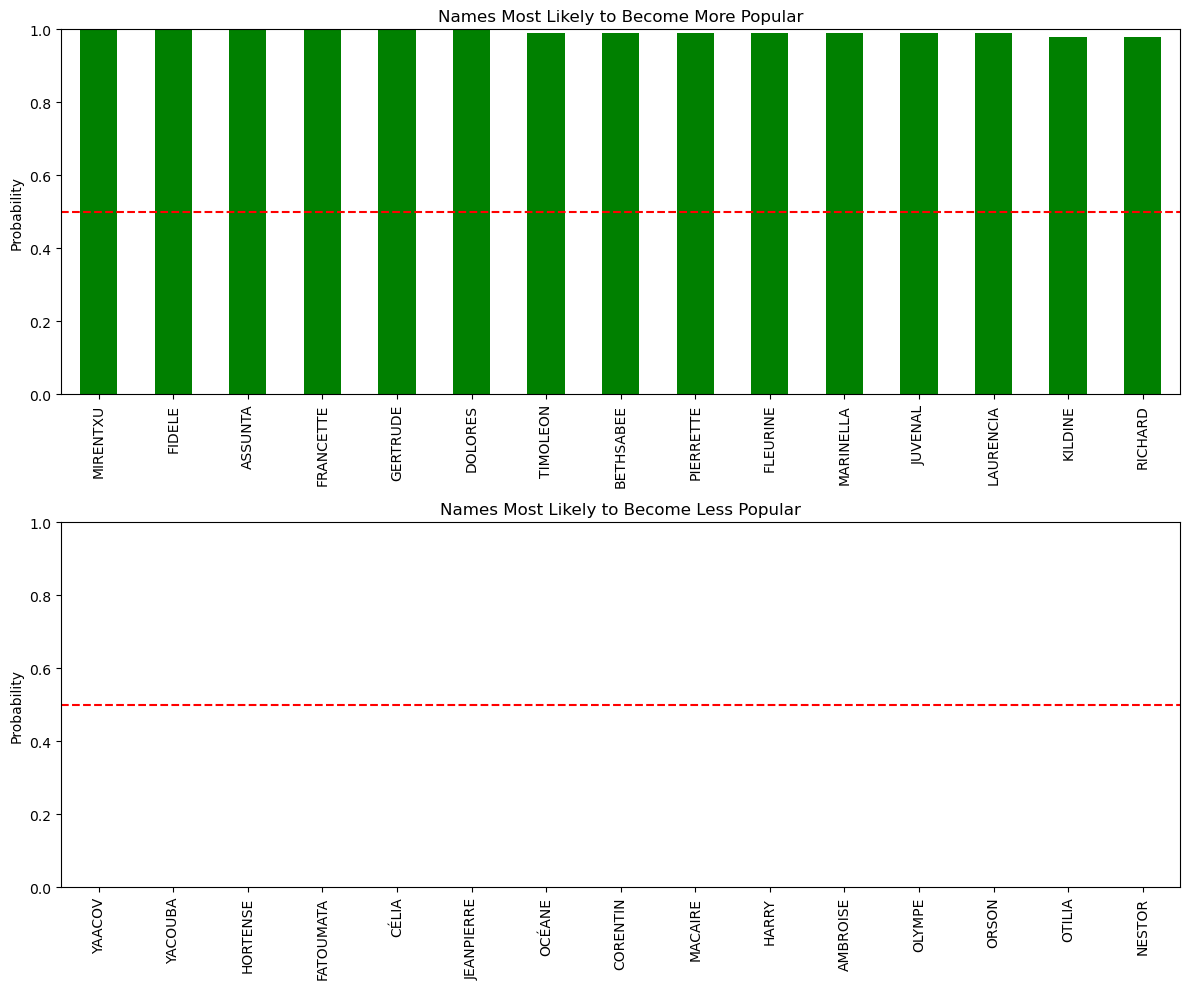

Total names analyzed: 4207
Predicted to become more popular: 1904
Predicted to become less popular: 2303


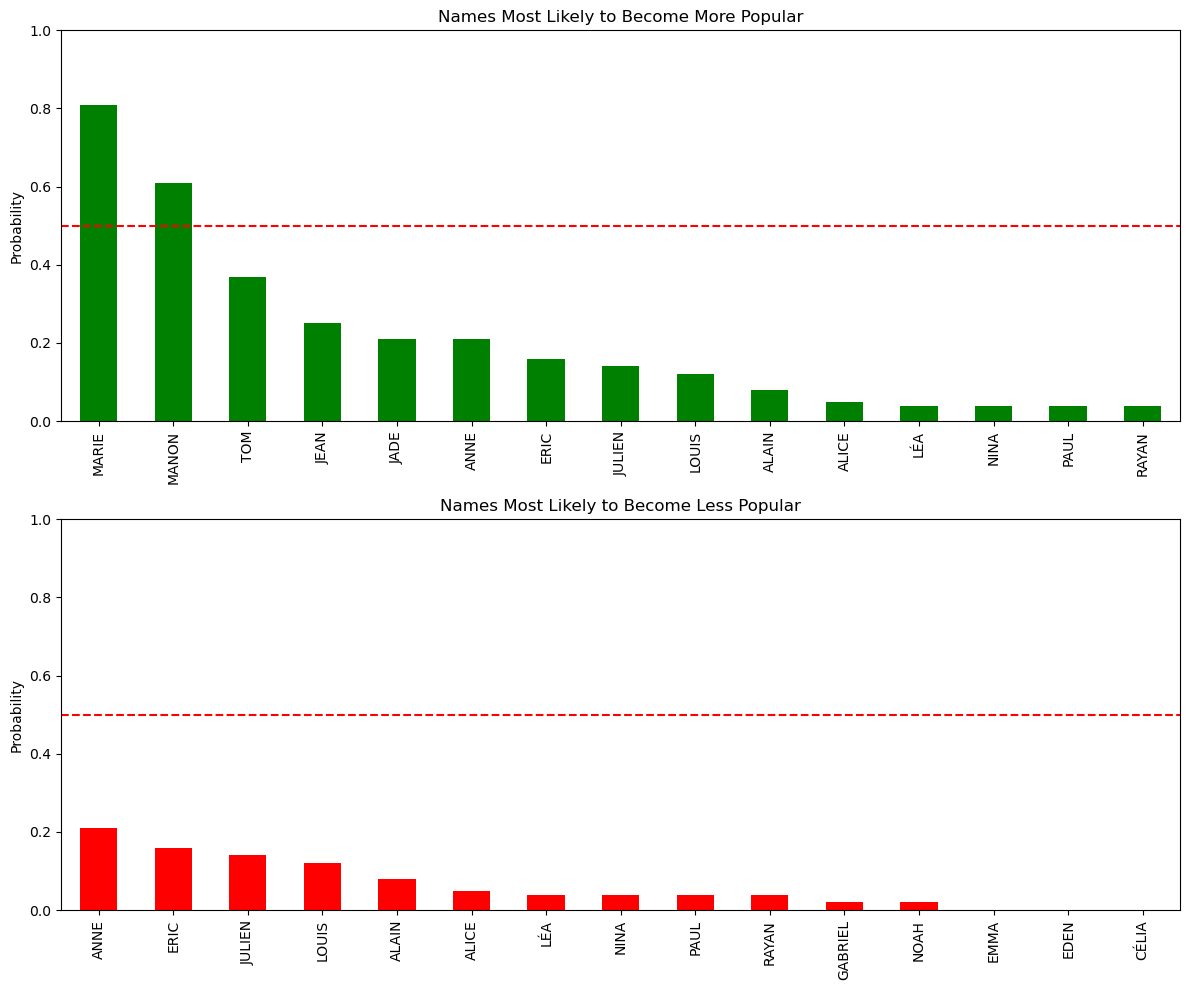

Total names analyzed: 20
Predicted to become more popular: 2
Predicted to become less popular: 18
           name  year  count  will_be_more_popular  probability  \
4244      ALAIN  2022   6179                     0         0.08   
5908      ALICE  2022   6444                     0         0.05   
10000      ANNE  2022   8682                     0         0.21   
32925     CÉLIA  2022   7757                     0         0.00   
38987      EDEN  2022   7692                     0         0.00   
42066      EMMA  2022   6394                     0         0.00   
43312      ERIC  2022   6474                     0         0.16   
52503   GABRIEL  2022   6543                     0         0.02   
70859      JADE  2022   6337                     0         0.21   
71560      JEAN  2022  10884                     0         0.25   
75440    JULIEN  2022   7480                     0         0.14   
84667     LOUIS  2022  14266                     0         0.12   
87134       LÉA  2022  52960   

In [151]:
predictions = predict_future_popularity(model, df_with_target)

# Visualize the results
visualize_popularity_predictions(predictions)

# Make prediction for a specific name
name_prediction = predict_future_popularity(model, df_with_target, name=top_20_names)
visualize_popularity_predictions(name_prediction)

print(name_prediction)

In [1]:
print(model)

NameError: name 'model' is not defined